# Multicollinearity of Features

## Introduction

Now that you've begun moving towards regression models with multiple predictors, let's explore what it means when predictors are correlated with each other and how this relates to the independence assumption of linear regression.

## Objectives
You will be able to:
* Explain why multicollinearity is an issue with linear regression
* Create and Interpret a correlation matrix/heatmap and scatter matrix
* Identify if variables are exhibiting collinearity

## Possible negative impacts of multicollinearity


When performing a regression analysis, the main goal is to identify the relationship between each predictor and the outcome variable. The interpretation of a regression coefficient is that it represents the average change in the dependent variable for each 1 unit change in a predictor, assuming that all the other predictor variables are kept constant.
And it is exactly because of that reason that multicollinearity can cause problems.

Because the idea behind regression is that you can change one variable and keep the others constant, correlation is a problem, because it indicates that changes in one predictor are associated with changes in another one as well. Because of this, the estimates of the coefficients can have big fluctuations as a result of small changes in the model. As a result, you may not be able to interpret the coefficients reliably or trust the p-values associated with correlated predictors.

You've seen that perfect multicollinearity can result when creating dummy variables and how this can be avoided by dropping one variable. In this lesson, you'll learn about methods to identify general multicollinearity and will remove predictors that are highly correlated with others. You'll learn about other (and less ad-hoc) ways to deal with multicollinearity later on.

## Identifying multicollinearity

To illustrate ways to identify multicollinearity, let's have a look at the "auto-mpg" data again.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
data = pd.read_csv('auto-mpg.csv')
data['horsepower'].astype(str).astype(int) # don't worry about this for now
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


To understand the correlation structure of the predictors, you'll take a copy of the data but this time without the target variable (mpg) in it. It's also advisable to remove the `'car name'` column as keeping it in won't lead to meaningful results.

In [2]:
data_pred = data.iloc[:,1:8]
data_pred.head()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,8,307.0,130,3504,12.0,70,1
1,8,350.0,165,3693,11.5,70,1
2,8,318.0,150,3436,11.0,70,1
3,8,304.0,150,3433,12.0,70,1
4,8,302.0,140,3449,10.5,70,1


For an initial idea on how the predictors relate, you can take a look at scatterplots between predictors. You can use Pandas to generate a scatter matrix as follows:

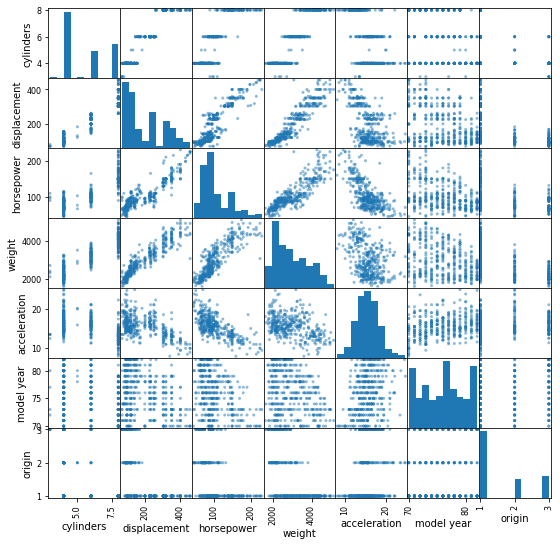

In [3]:
pd.plotting.scatter_matrix(data_pred,figsize  = [9, 9]);
plt.show()

This matrix has the cool feature that it returns scatterplots for relationships between two predictors, and histograms for a single feature on the diagonal. Have a quick look at this. When talking about correlation, what sort of scatter plots will catch our eye? Probably the ones with scatter plots that reveal some sort of linear relationship. For example, weight and displacement seem to be highly correlated. Weight and horsepower as well, and (not surprisingly) displacement and horsepower. This is nice, but it would be hard to examine each plot in detail when having a ton of features. Let's look at the correlation matrix instead. Instead of returning scatter plots and histograms, a correlation matrix returns pairwise correlations. Recall that correlations take a value between -1 and 1, -1 being a perfectly negative linear relationship, and +1 a perfectly positive linear relationship. 

In [4]:
data_pred.corr()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin
cylinders,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647,-0.568932
displacement,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855,-0.614535
horsepower,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,-0.455171
weight,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120,-0.585005
acceleration,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316,0.212746
model year,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000,0.181528
origin,-0.568932,-0.614535,-0.455171,-0.585005,0.212746,0.181528,1.000000


Note that correlations on the diagonal are automatically equal to one as they represent correlations between a variable and the variable itself. So when would you consider a correlation "high"? Generally, a correlation with an absolute value around 0.7-0.8 or higher is considered a high correlation. If we take 0.75 as a cut-off, how many high correlations do we have?

In [5]:
abs(data_pred.corr()) > 0.75

,cylinders,displacement,horsepower,weight,acceleration,model year,origin
cylinders,True,True,True,True,False,False,False
displacement,True,True,True,True,False,False,False
horsepower,True,True,True,True,False,False,False
weight,True,True,True,True,False,False,False
acceleration,False,False,False,False,True,False,False
model year,False,False,False,False,False,True,False
origin,False,False,False,False,False,False,True


It seems like the variables `'cylinder'`, `'displacement'`, `'horsepower'`, and `'weight'` are all pretty highly correlated among each other. 
Gaining that information was easy from a small correlation matrix, but what if it was larger?

Because the `corr` returns a dataframe, a neat fix is to use `stack` and a subset to return only the highly correlated pairs.

In [6]:
# save absolute value of correlation matrix as a data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking

df=data_pred.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df['pairs'] = list(zip(df.level_0, df.level_1))

# set index to pairs
df.set_index(['pairs'], inplace = True)

#d rop level columns
df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
df.drop_duplicates(inplace=True)

Now use a similar subset as done previously.

In [7]:
df[(df.cc>.75) & (df.cc <1)]

,cc
pairs,
"(cylinders, displacement)",0.950823
"(weight, displacement)",0.932994
"(weight, cylinders)",0.897527
"(horsepower, displacement)",0.897257
"(horsepower, weight)",0.864538
"(horsepower, cylinders)",0.842983


A few lines of code, cleverly using pandas, produces a readable list of variable pairs and their correlation.  The code can be scaled in case our predictor base grows (sometimes models have 100s of predictors!).

**NOTE** There will be cases when an analyst _should_ see all the highly correlated variables, including variables that are correlated 1 to 1. The code can be adjusted to those conditions.


With the variables `'cylinder'`, `'displacement'`, `'horsepower'`, and `'weight'` so highly correlated, you would typically remove _three_ of them in order to remove collinear features. 


Another option is to use a heatmap to render the correlation matrix as a visualization. 

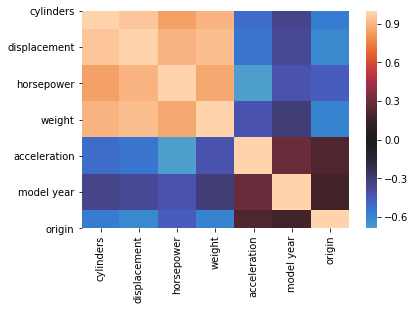

In [8]:
import seaborn as sns
sns.heatmap(data_pred.corr(), center=0);

You can see that light pink colors represent high correlations.

## Summary

In this section, you learned about multicollinearity and how it can negatively affect the regression outcome. Additionally, you learned about correlation matrices and heatmaps to visually inspect multicollinearity.